<a href="https://colab.research.google.com/github/SizovV/Music_Genres/blob/main/part2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np 
import os, sys

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
data_root = 'drive/MyDrive/data'
data_embeddings = os.path.join(data_root, 'embeddings')

In [22]:
# data = pd.read_csv(os.path.join(data_root, 'data.csv'))
# train_id = np.load(os.path.join(data_root, 'train.npy'))
# test_id = np.load(os.path.join(data_root, 'test.npy'))
# validate_id = np.load(os.path.join(data_root, 'val.npy'))

In [18]:
# bad_files = np.array([98569, 98565, 98567])
# train_id = train_id[train_id != bad_files[0]]
# train_id = train_id[train_id != bad_files[1]]
# train_id = train_id[train_id != bad_files[2]]


# test_id = test_id[test_id != bad_files[0]]
# test_id = test_id[test_id != bad_files[1]]
# test_id = test_id[test_id != bad_files[2]]


# validate_id = validate_id[validate_id != bad_files[0]]
# validate_id = validate_id[validate_id != bad_files[1]]
# validate_id = validate_id[validate_id != bad_files[2]]

In [19]:
# np.save(os.path.join(data_root, 'train.npy'), train_id)
# np.save(os.path.join(data_root, 'test.npy'), test_id)
# np.save(os.path.join(data_root, 'val.npy'), validate_id)

In [23]:
# data = data.set_index('track_id')

In [8]:
# data_train = data.loc[train_id]
# data_test = data.loc[test_id]
# data_val = data.loc[validate_id]

In [9]:
# data_train.genre_top.value_counts()

International    800
Folk             800
Pop              800
Hip-Hop          800
Experimental     799
Instrumental     799
Electronic       799
Rock             799
Name: genre_top, dtype: int64

In [11]:
# data_test.genre_top.value_counts()

Instrumental     100
International    100
Rock             100
Pop              100
Experimental     100
Electronic       100
Hip-Hop          100
Folk             100
Name: genre_top, dtype: int64

In [12]:
# data_val.genre_top.value_counts()

Instrumental     100
International    100
Rock             100
Pop              100
Experimental     100
Electronic       100
Hip-Hop          100
Folk             100
Name: genre_top, dtype: int64

In [24]:
# # convert embeddings' separated files to one file for train, validation and test
# songs = list()
# targets = list()
# for ind in tqdm(data.index):
#   song_name = os.path.join(data_embeddings,
#                                  str(ind) + '.npy')
#   with open(song_name, 'rb') as f:
#       song = np.load(f)
#   target = data.loc[ind]['genre_top']
#   songs.append(song)
#   targets.append(target)

# emb = pd.DataFrame({'song': songs, 'genre': targets})
# emb = emb.set_index(data.index)
# emb.to_pickle(os.path.join(data_root,
#                                  'embeddings_packed.pkl'))

In [23]:
# dataloader
class MusicDataset(torch.utils.data.Dataset):
    """Music dataset."""
 
    def __init__(self, data_file, select):

        self.data = pd.read_pickle(data_file)
        self.classes = {}
        for ind, genre in enumerate(self.data['genre'].unique()):
            self.classes[genre] = ind

        with open(select, 'rb') as f:
            self.select = np.load(f)
 
    def __len__(self):
        return len(self.select)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[self.select[idx]]
        return {'song': sample['song'], 'target': self.classes[sample['genre']]}

In [24]:
embd_packed = os.path.join(data_root, 'embeddings_packed.pkl')
data_train = MusicDataset(embd_packed, os.path.join(data_root, 'train.npy'))
data_test = MusicDataset(embd_packed, os.path.join(data_root, 'test.npy'))
data_val = MusicDataset(embd_packed, os.path.join(data_root, 'val.npy'))
torch.manual_seed(42)

In [25]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=100, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=100, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=100, shuffle=True)

In [26]:
# net
class LSTMClassifier(nn.Module):
    def __init__(self, input_feature_dim, sequence_length, n_classes):
        super(LSTMClassifier, self).__init__()
        self.rnn1 = nn.LSTM(input_feature_dim,
                            64, 
                            batch_first=True)
        self.fcn1 = nn.Linear(64, 8)

    def forward(self, x):
        out, hidden = self.rnn1(x)
        # берём только последний выход
        output = self.fcn1(out[:, -1, :])
        return output

In [30]:
# fit
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device='cuda:0',
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # Move Batch to GPU
            songs = batch['song'].to(device)
            labels = batch['target'].to(device)
            predicted = model(songs)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device='cuda:0'):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            songs = batch['song'].to(device)
            labels = batch['target'].to(device)
            predicted = model(songs)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    epoch_train_acc = []
    epoch_eval_acc = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        epoch_train_acc.append(train_metrics['accuracy'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics['loss'])
        epoch_eval_acc.append(validation_metrics['accuracy'])
    return {'train_loss': epoch_train_losses,
            'train_acc': epoch_train_acc,
            'val_loss': epoch_eval_losses,
            'val_acc': epoch_eval_acc}

In [37]:
lstmc = LSTMClassifier(128, 31, 8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstmc.parameters(), lr=0.005)

In [38]:
h = fit(lstmc, 10, train_dataloader, val_dataloader, optimizer, criterion)

Train Epoch: 0



Validation Epoch: 0



Train Epoch: 1



Validation Epoch: 1



Train Epoch: 2



Validation Epoch: 2



Train Epoch: 3



Validation Epoch: 3



Train Epoch: 4



Validation Epoch: 4



Train Epoch: 5



Validation Epoch: 5



Train Epoch: 6



Validation Epoch: 6



Train Epoch: 7



Validation Epoch: 7



Train Epoch: 8



Validation Epoch: 8



Train Epoch: 9



Validation Epoch: 9


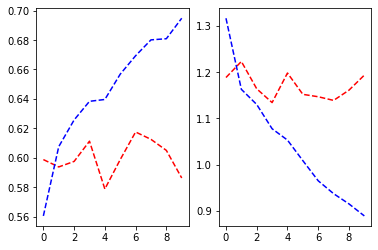

In [41]:
plt.figure()
plt.subplot(121)
plt.plot(h['val_acc'], 'r--')
plt.plot(h['train_acc'], 'b--')

plt.subplot(122)
plt.plot(range(len(h['val_loss'])), h['val_loss'], 'r--')
plt.plot(range(len(h['train_loss'])), h['train_loss'], 'b--')
plt.show()

In [43]:
with torch.no_grad():
            validation_metrics = validate(
                model=lstmc,
                data_loader=test_dataloader,
                criterion=criterion
            )

In [44]:
validation_metrics

{'accuracy': 0.54, 'loss': 1.3262138366699219}